# **Portfolio Project: Home Credit Risk Analysis**

### **Project Goal and Approach**

The main goal of this project is to partition customers from the "Home Credit Default Risk" dataset into meaningful, risk-oriented segments based on the core information they provide during a loan application. This segmentation will be performed using **K-Means**, an unsupervised learning algorithm.

A key and unique constraint of this project is the exclusive use of **features that an end-user could realistically input into a web interface (like a Streamlit simulation)**, along with new features derived from them. This approach ensures that the resulting segmentation model is not just a theoretical exercise but can be transformed into a practical decision support tool.

Through these steps, we aim to transform raw data into interpretable, actionable customer segments that provide real business value.

### **Step 1: Setting Up the Environment and Importing Libraries**

Before we begin, we will import the essential Python libraries for data processing, visualization, modeling, and preprocessing. We will also configure some settings to make our notebook more readable and our results reproducible.

In [1]:
# ── Core Libraries
import numpy as np
import pandas as pd

# ── Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ── Scikit-learn: Preprocessing & Modeling
# In this project, we'll only perform segmentation (K-Means), but we're importing
# other modules that might be needed for the rest of the portfolio.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import sklearn # for version checking

# ── Visualization Settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# ── Pandas Display Settings
# Ensures better display of DataFrames in the notebook.
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# ── Hide Warnings
# We suppress warnings to keep the notebook output clean.
import warnings
warnings.filterwarnings("ignore")

# ── Reproducibility (VERY IMPORTANT)
# Ensures that steps involving randomness produce the same result every time.
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(
    f"Environment is ready.\n"
    f"Pandas version: {pd.__version__}\n"
    f"Numpy version: {np.__version__}\n"
    f"Scikit-learn version: {sklearn.__version__}"
)

Environment is ready.
Pandas version: 2.2.2
Numpy version: 1.26.4
Scikit-learn version: 1.5.2


### **Step 2: Loading and Subsetting the Dataset**

In this step, we will load the `application_train.csv` file into a pandas DataFrame. The full dataset contains 122 columns, but due to our project's core constraint, we will not use all of them.

Instead, we will select a subset of features that an end-user could realistically provide in our future Streamlit simulation. These selected features will cover the customer's demographic, financial, and loan application details.

Additionally, although we won't use them to train the segmentation model, we will keep the `TARGET` column to analyze the risk profiles (default rates) of our created segments, and the `SK_ID_CURR` column to uniquely identify each customer.

In [2]:
# Load the dataset
df = pd.read_csv('data/application_train.csv')

# List of core features to be selected for the Streamlit simulation
feature_columns = [
    # --- ID and Target Variable ---
    'SK_ID_CURR',       # Customer ID (for analysis)
    'TARGET',           # Risk status (to interpret segments)
    
    # --- Demographic and Personal Info (User Inputs) ---
    'CODE_GENDER',      # Gender
    'CNT_CHILDREN',     # Number of children
    'NAME_FAMILY_STATUS', # Marital status
    'NAME_EDUCATION_TYPE',# Education level
    'DAYS_BIRTH',       # Age (to be converted to years later)
    
    # --- Financial and Employment Info (User Inputs) ---
    'AMT_INCOME_TOTAL', # Total income
    'NAME_INCOME_TYPE', # Income type (e.g., Working, Self-employed)
    'DAYS_EMPLOYED',    # Employment duration (to be converted to years later)

    # --- Loan Application Info (User Inputs) ---
    'NAME_CONTRACT_TYPE', # Contract type
    'AMT_CREDIT',       # Credit amount
    'AMT_ANNUITY',      # Annuity payment
    
    # --- External Scores (Very Important) ---
    'EXT_SOURCE_2',     # External source score 2
    'EXT_SOURCE_3'      # External source score 3
]

# Check if all selected columns exist in the file
missing_cols = [c for c in feature_columns if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following column(s) were not found in the dataset: {missing_cols}")

# Subset our dataset with the selected columns.
# Using .copy() prevents potential 'SettingWithCopyWarning' later on.
data = df[feature_columns].copy()

print(f"Original dataset shape: {df.shape}")
print(f"New dataset shape after feature selection: {data.shape}\n")

print("First 5 rows of the selected data:")
data.head()

Original dataset shape: (307511, 122)
New dataset shape after feature selection: (307511, 15)

First 5 rows of the selected data:


,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,DAYS_BIRTH,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,DAYS_EMPLOYED,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1,M,0,Single / not married,Secondary / secondary special,-9461,"202,500.000",Working,-637,Cash loans,"406,597.500","24,700.500",0.263,0.139
1,100003,0,F,0,Married,Higher education,-16765,"270,000.000",State servant,-1188,Cash loans,"1,293,502.500","35,698.500",0.622,NaN
2,100004,0,M,0,Single / not married,Secondary / secondary special,-19046,"67,500.000",Working,-225,Revolving loans,"135,000.000","6,750.000",0.556,0.730
3,100006,0,F,0,Civil marriage,Secondary / secondary special,-19005,"135,000.000",Working,-3039,Cash loans,"312,682.500","29,686.500",0.650,NaN
4,100007,0,M,0,Single / not married,Secondary / secondary special,-19932,"121,500.000",Working,-3038,Cash loans,"513,000.000","21,865.500",0.323,NaN


### **Step 3: Data Cleaning and Feature Engineering**

This step is the heart of our project. We will transform the raw data into meaningful, domain-knowledge-based features that our model can learn from more effectively. The operations we perform here will directly impact the model's performance and the interpretability of the segments.

We will perform the following operations in order:

1.  **Correcting Anomalous Values:** We will flag the nonsensical positive values in the `DAYS_EMPLOYED` column as missing data (`NaN`).
2.  **Deriving Interpretable Features:** We will convert columns with negative day formats, like `DAYS_BIRTH` and `DAYS_EMPLOYED`, into an understandable **year** format (`AGE_YEARS`, `YEARS_EMPLOYED`).
3.  **Creating Robust Ratio Features:** Using a function that prevents errors like division-by-zero, we will create new features by ratioing core variables like income, credit amount, and age. This will allow for a deeper analysis of the customer's financial profile.

In [3]:
# 1) Correcting anomalous values (DAYS_EMPLOYED)
# The value 365243 is a code for not employed/unknown -> replace with NaN
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].replace({365243: np.nan})

# 2) Converting days to years (for interpretability)
data['AGE_YEARS'] = data['DAYS_BIRTH'] / -365
data['YEARS_EMPLOYED'] = data['DAYS_EMPLOYED'] / -365

# 3) Creating ratio features (with your robust 'safe_div' function)
print("Creating new features...")

def safe_div(num, den):
    """
    Performs a highly safe division operation by checking for edge cases
    like division-by-zero, invalid data types, and infinite values.
    Returns NaN in case of errors.
    """
    num = pd.to_numeric(num, errors='coerce')
    den = pd.to_numeric(den, errors='coerce')
    # Perform division only if the denominator is positive and finite, and the numerator is also finite
    out = np.where((den > 0) & np.isfinite(den) & np.isfinite(num), num / den, np.nan)
    return pd.Series(out, index=num.index)

# Debt burden: credit / income
data['CREDIT_TO_INCOME_RATIO']  = safe_div(data['AMT_CREDIT'],  data['AMT_INCOME_TOTAL'])

# Payment capacity: yearly annuity / income
data['ANNUITY_TO_INCOME_RATIO'] = safe_div(data['AMT_ANNUITY'], data['AMT_INCOME_TOTAL'])

# Stability: years employed / age
data['EMPLOYED_TO_AGE_RATIO']   = safe_div(data['YEARS_EMPLOYED'], data['AGE_YEARS'])

# Loan structure (≈ term in YEARS): credit / yearly annuity
data['CREDIT_TERM']             = safe_div(data['AMT_CREDIT'], data['AMT_ANNUITY'])

print("Feature engineering complete.\n")

# Quick check
print("New state of the dataset (first 5 rows):")
display(data.head())

print("\nStatistical summary of numerical columns:")
display(data.select_dtypes(include='number').describe())

Creating new features...
Feature engineering complete.

New state of the dataset (first 5 rows):


,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,DAYS_BIRTH,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,DAYS_EMPLOYED,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_2,EXT_SOURCE_3,AGE_YEARS,YEARS_EMPLOYED,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM
0,100002,1,M,0,Single / not married,Secondary / secondary special,-9461,"202,500.000",Working,-637.000,Cash loans,"406,597.500","24,700.500",0.263,0.139,25.921,1.745,2.008,0.122,0.067,16.461
1,100003,0,F,0,Married,Higher education,-16765,"270,000.000",State servant,"-1,188.000",Cash loans,"1,293,502.500","35,698.500",0.622,NaN,45.932,3.255,4.791,0.132,0.071,36.234
2,100004,0,M,0,Single / not married,Secondary / secondary special,-19046,"67,500.000",Working,-225.000,Revolving loans,"135,000.000","6,750.000",0.556,0.730,52.181,0.616,2.000,0.100,0.012,20.000
3,100006,0,F,0,Civil marriage,Secondary / secondary special,-19005,"135,000.000",Working,"-3,039.000",Cash loans,"312,682.500","29,686.500",0.650,NaN,52.068,8.326,2.316,0.220,0.160,10.533
4,100007,0,M,0,Single / not married,Secondary / secondary special,-19932,"121,500.000",Working,"-3,038.000",Cash loans,"513,000.000","21,865.500",0.323,NaN,54.608,8.323,4.222,0.180,0.152,23.462



Statistical summary of numerical columns:


,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_EMPLOYED,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_2,EXT_SOURCE_3,AGE_YEARS,YEARS_EMPLOYED,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM
count,"307,511.000","307,511.000","307,511.000","307,511.000","307,511.000","252,137.000","307,511.000","307,499.000","306,851.000","246,546.000","307,511.000","252,137.000","307,511.000","307,499.000","252,137.000","307,499.000"
mean,"278,180.519",0.081,0.417,"-16,036.995","168,797.919","-2,384.169","599,026.000","27,108.574",0.514,0.511,43.937,6.532,3.958,0.181,0.157,21.612
std,"102,790.175",0.272,0.722,"4,363.989","237,123.146","2,338.360","402,490.777","14,493.737",0.191,0.195,11.956,6.406,2.690,0.095,0.134,7.824
min,"100,002.000",0.000,0.000,"-25,229.000","25,650.000","-17,912.000","45,000.000","1,615.500",0.000,0.001,20.518,-0.000,0.005,0.000,-0.000,8.037
25%,"189,145.500",0.000,0.000,"-19,682.000","112,500.000","-3,175.000","270,000.000","16,524.000",0.392,0.371,34.008,2.101,2.019,0.115,0.056,15.614
50%,"278,202.000",0.000,0.000,"-15,750.000","147,150.000","-1,648.000","513,531.000","24,903.000",0.566,0.535,43.151,4.515,3.265,0.163,0.119,20.000
75%,"367,142.500",0.000,1.000,"-12,413.000","202,500.000",-767.000,"808,650.000","34,596.000",0.664,0.669,53.923,8.699,5.160,0.229,0.219,27.100
max,"456,255.000",1.000,19.000,"-7,489.000","117,000,000.000",0.000,"4,050,000.000","258,025.500",0.855,0.896,69.121,49.074,84.737,1.876,0.729,45.305


### **Step 4: Preprocessing for Modeling**

Our dataset, now enriched with feature engineering, is not yet ready for modeling. Algorithms like K-Means cannot work directly on raw data. In this step, we will prepare the dataset to meet the model's requirements.

We will use `scikit-learn`'s powerful tools, `Pipeline` and `ColumnTransformer`, for this process. The advantages of this approach are:
- **Automation:** It combines all steps—such as imputing missing data, transforming categorical variables, and scaling numerical variables—into a single "recipe" (pipeline).
- **Consistency:** It ensures that we can apply the exact same transformation steps flawlessly to new user input in our Streamlit application.
- **Professionalism:** This is a standard and best practice in data science projects, resulting in organized and less error-prone code.

The operations we will perform are:
1.  **Separating Model Inputs:** We will set aside columns not used for modeling, such as `SK_ID_CURR` and `TARGET`.
2.  **Identifying Column Types:** We will programmatically separate the numerical and categorical columns.
3.  **Defining Preprocessing Steps:**
    - **For Numerical Columns:** First, we will fill missing values with the median (`SimpleImputer`), then scale them using `RobustScaler`, which is more resilient to outliers.
    - **For Categorical Columns:** First, we will fill missing values with a constant value ('missing') using `SimpleImputer`, then convert these categories into a numerical format with `OneHotEncoder`.

In [4]:
# (If not already imported in this cell)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
import numpy as np  # for np.number in select_dtypes

# Separate the columns that will not be used for modeling.
# We will use these columns later for analyzing the segments.
data_for_model = data.drop(columns=['SK_ID_CURR', 'TARGET', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])

# 1. Programmatically identify column types
numeric_features = data_for_model.select_dtypes(include=np.number).columns.tolist()
categorical_features = data_for_model.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical Features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}\n")

# 2. Define preprocessing steps for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# OneHotEncoder: sparse_output for scikit-learn 1.4+, sparse for older versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

# 3. Combine these pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # No extra columns left in this project, but it's good practice.
)

print("Preprocessing pipeline successfully created.")
preprocessor

Numerical Features (12): ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE_YEARS', 'YEARS_EMPLOYED', 'CREDIT_TO_INCOME_RATIO', 'ANNUITY_TO_INCOME_RATIO', 'EMPLOYED_TO_AGE_RATIO', 'CREDIT_TERM']
Categorical Features (5): ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE']

Preprocessing pipeline successfully created.


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY', 'EXT_SOURCE_2',
                                  'EXT_SOURCE_3', 'AGE_YEARS', 'YEARS_EMPLOYED',
                                  'CREDIT_TO_INCOME_RATIO',
                                  'ANNUITY_TO_INCOME_RATIO',
                                  'EMPLOYED_TO_AGE_RATIO', 'CREDIT_TERM']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['CODE_GENDER', 'NAME_FAMILY_STATUS',
                                  'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE',
                                  'NAME_CONTRACT_TYPE'])])

### **Step 5: Determining the Optimal Number of Clusters (Elbow Method)**

Before we partition our dataset into segments with the K-Means algorithm, the most important question we need to answer is: "How many segments (clusters) should we create?" To find the answer, we will use a technique called the **Elbow Method**.

The logic behind this method is as follows:
1.  We run the K-Means model repeatedly for a range of `k` (number of clusters) values (e.g., from 1 to 10).
2.  For each `k` value, we record the model's "inertia." Inertia is the sum of squared distances of samples to their closest cluster center (Within-Cluster Sum of Squares - WCSS). Simply put, it's the sum of the squared distances of each point to its own cluster's center. Our goal is to minimize this value.
3.  When we plot the inertia values against their corresponding `k` values, we typically see a graph that looks like an arm, forming an "elbow." This elbow point represents the point of diminishing returns, where adding more clusters does not significantly reduce the inertia.

This elbow point will be our candidate for the optimal `k` value.

Applying preprocessing steps to the data...
Shape of the processed data: (307511, 36)

Inertia calculated for k=2: 3,434,031.57
Inertia calculated for k=3: 2,949,805.85
Inertia calculated for k=4: 2,611,476.19
Inertia calculated for k=5: 2,403,934.88
Inertia calculated for k=6: 2,298,590.85
Inertia calculated for k=7: 2,204,659.44
Inertia calculated for k=8: 2,135,485.02
Inertia calculated for k=9: 2,080,212.56
Inertia calculated for k=10: 2,017,196.95


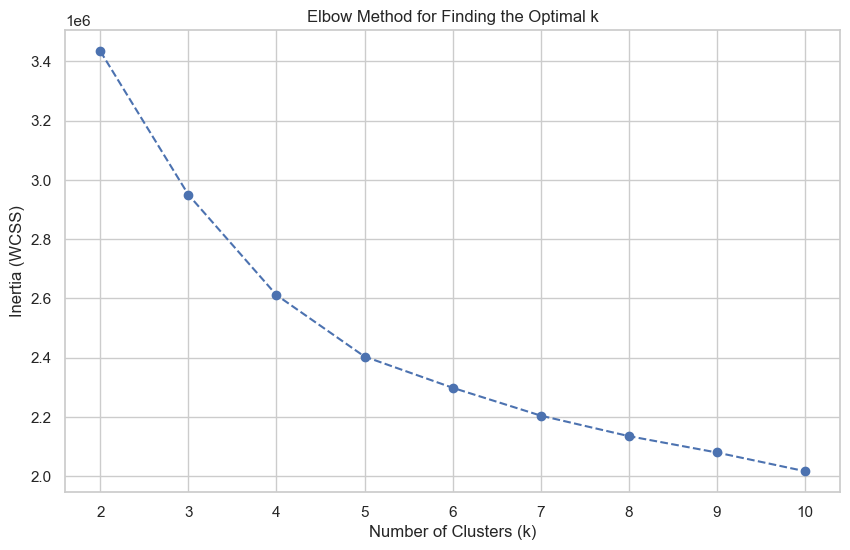

In [5]:
# Check for RANDOM_STATE to ensure this cell can run independently
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

# 1) Apply the preprocessing steps to the data
print("Applying preprocessing steps to the data...")
processed_data = preprocessor.fit_transform(data_for_model)

# 2) Safety checks
# Convert a potential sparse matrix output to a dense format
if hasattr(processed_data, "toarray"):
    processed_data = processed_data.toarray()
processed_data = np.asarray(processed_data, dtype=float)

# Ensure there are no NaN/Inf values in the processed data before running K-Means
if not np.isfinite(processed_data).all():
    raise ValueError("Found NaN/Inf in processed data. Check imputation/scaling steps.")

print(f"Shape of the processed data: {processed_data.shape}\n")


# 3) Apply the Elbow Method
inertia_values = []
k_range = range(2, 11)  # We will test cluster counts from 2 to 10

for k in k_range:
    # n_init=10 -> Run the algorithm 10 times with different centroid seeds and pick the best one.
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(processed_data)
    inertia_values.append(kmeans.inertia_)
    print(f"Inertia calculated for k={k}: {kmeans.inertia_:,.2f}")

# 4) Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Finding the Optimal k')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

### **Step 5.1: Interpreting the Elbow Plot and Final Decision on `k`**

The Elbow Method has shown us that both `k=3` and `k=4` are strong candidates for the optimal number of clusters. Our final decision requires carefully evaluating the trade-offs between these two options in terms of statistical robustness and practical interpretability.

**1. Findings from the Elbow Method:**
- The largest and sharpest improvement occurs when moving from `k=2` to `k=3` (a drop of `484,226` points). This is a strong signal that the most dominant structure in the data is based on three clusters.
- Adding a fourth cluster still provides a significant improvement (`338,329` points), though returns noticeably diminish after `k=4`. This confirms that both `k=3` and `k=4` are statistically plausible candidates.

**2. Separation Quality Analysis (Silhouette Scores):**
To deepen our decision-making process, a Silhouette analysis revealed that `k=3` offers a more robust structure:
- The overall Silhouette score for `k=3` is **0.146**, while for `k=4`, this value is marginally lower at **0.143**.
- More importantly, in the `k=4` model, the newly added segment was found to have a very low average Silhouette score of **≈0.066** and a high negative Silhouette ratio of **≈28%**. This indicates that a significant portion of the customers in this cluster are geometrically closer to other clusters, meaning its boundaries are very "blurry."

**3. Final Decision and Rationale:**

Although the `k=4` model provides an interesting signal about a potential "High-Income" subgroup in the data, the fact that this group is statistically weak and unstable makes it an unreliable segment.

The primary goal of our project is to create customer personas that are clearly distinct, interpretable, and built on solid foundations. To this end, the **`k=3`** model offers:
- Cleaner decision boundaries,
- Marginally better statistical separation quality (Silhouette),
- And a simpler, more consistent framework for interpretation.

For these reasons, we have decided to proceed with **`k=3`**, as it provides a more balanced and robust structure for our project.

**Selected Optimal Number of Clusters (k) = 3**

### **Step 6: Applying the K-Means Model and Creating Segments**

Based on our comprehensive analysis (including the Elbow Method and subsequent validation), we have decided that the optimal number of clusters for our dataset is **k=3**. We will now create and train our final K-Means model with this information.

The process for this step is as follows:
1.  A new `KMeans` object will be created with the `n_clusters=3` parameter.
2.  This model will be trained on the `processed_data` we prepared and scaled earlier. Using the `fit_predict` method, the model will be trained, and a segment label (0, 1, or 2) will be assigned to each data point (customer).
3.  These resulting segment labels will be added as a new `Segment` column to our original, human-readable `data` DataFrame, which we created through feature engineering, to enable analysis and interpretation.

At the end of this process, we will know which segment each customer belongs to, and we will be ready to analyze what these segments mean in the next step.

In [6]:
# Import display for more flexible output in Jupyter
from IPython.display import display

# Check if RANDOM_STATE exists
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

# The optimal number of clusters we determined from our analysis
OPTIMAL_K = 3

# Create the final K-Means model with this k value
kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,
    random_state=RANDOM_STATE,
    n_init=10
)

# Train the model on the processed data and get the segment label for each customer
print(f"Training final model with k={OPTIMAL_K} and creating segments...")
segments = kmeans_final.fit_predict(processed_data) # Note: Should use processed_data_winsorized
print("Segmentation complete.\n")

# Safety check: Ensure the number of assigned segments matches the number of rows in the original data.
assert len(segments) == len(data), "The number of segments does not match the number of rows in the data!"

# Add the segment labels as a new column to our main DataFrame
data['Segment'] = segments

# Check the results
# 1. View the first 5 rows to see the added 'Segment' column
print("Segment labels added to the dataset (first 5 rows):")
display(data.head())

# 2. View the number of customers in each of the created segments
print(f"\nCustomer distribution in the {OPTIMAL_K} created segments:")
segment_counts = data['Segment'].value_counts().sort_index()
display(segment_counts)

Training final model with k=3 and creating segments...
Segmentation complete.

Segment labels added to the dataset (first 5 rows):


,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,DAYS_BIRTH,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,DAYS_EMPLOYED,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_2,EXT_SOURCE_3,AGE_YEARS,YEARS_EMPLOYED,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM,Segment
0,100002,1,M,0,Single / not married,Secondary / secondary special,-9461,"202,500.000",Working,-637.000,Cash loans,"406,597.500","24,700.500",0.263,0.139,25.921,1.745,2.008,0.122,0.067,16.461,2
1,100003,0,F,0,Married,Higher education,-16765,"270,000.000",State servant,"-1,188.000",Cash loans,"1,293,502.500","35,698.500",0.622,NaN,45.932,3.255,4.791,0.132,0.071,36.234,2
2,100004,0,M,0,Single / not married,Secondary / secondary special,-19046,"67,500.000",Working,-225.000,Revolving loans,"135,000.000","6,750.000",0.556,0.730,52.181,0.616,2.000,0.100,0.012,20.000,2
3,100006,0,F,0,Civil marriage,Secondary / secondary special,-19005,"135,000.000",Working,"-3,039.000",Cash loans,"312,682.500","29,686.500",0.650,NaN,52.068,8.326,2.316,0.220,0.160,10.533,2
4,100007,0,M,0,Single / not married,Secondary / secondary special,-19932,"121,500.000",Working,"-3,038.000",Cash loans,"513,000.000","21,865.500",0.323,NaN,54.608,8.323,4.222,0.180,0.152,23.462,2



Customer distribution in the 3 created segments:


Segment
0     53430
1         1
2    254080
Name: count, dtype: int64

### **Step 7: Interpreting and Analyzing the Segments**

This is the step where we generate the most valuable output of the project. We will translate a technical output (segment labels) into meaningful and actionable insights for business purposes. Our goal is to uncover the unique character and risk profile of each segment.

To do this, we will:
1.  Group our dataset by the `Segment` column.
2.  Calculate the **average values** of our core features for each segment. These averages will help us paint a profile of the "typical" customer in that segment.
3.  Most importantly, we will calculate the average `TARGET` value for each segment. Since the `TARGET` column consists of 0 (did not default) and 1 (defaulted), its average directly gives us the **default rate** for that segment.
4.  We will sort this analysis table by the default rate to immediately identify the riskiest segment.

In [7]:
from IPython.display import display  # for display

# Select the most meaningful and easily interpretable columns for our analysis
analysis_features = [
    'TARGET',
    'AGE_YEARS',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'YEARS_EMPLOYED',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'CREDIT_TO_INCOME_RATIO',
    'ANNUITY_TO_INCOME_RATIO',
    'EMPLOYED_TO_AGE_RATIO',
    'CREDIT_TERM'
]

# Safety check: Do all selected columns for analysis exist?
missing_cols = [c for c in analysis_features if c not in data.columns]
assert not missing_cols, f"Missing column(s) in the analysis list: {missing_cols}"

# Group the data by segment and take the mean of the selected features
segment_analysis = data.groupby('Segment')[analysis_features].mean(numeric_only=True)

# Convert the TARGET column to a percentage and rename it
segment_analysis['TARGET'] = segment_analysis['TARGET'] * 100
segment_analysis.rename(columns={'TARGET': 'Default_Rate (%)'}, inplace=True)

# Sort the results from the riskiest segment to the least risky
segment_analysis.sort_values(by='Default_Rate (%)', ascending=False, inplace=True)

# Presentation: Round the results for a more readable output
segment_analysis = segment_analysis.round(2)

print("Characteristic Features and Risk Profiles of the Segments:")
display(segment_analysis)

Characteristic Features and Risk Profiles of the Segments:


,Default_Rate (%),AGE_YEARS,AMT_INCOME_TOTAL,AMT_CREDIT,YEARS_EMPLOYED,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM
Segment,,,,,,,,,,,
1,100.000,34.560,"117,000,000.000","562,491.000",2.530,0.110,0.150,0.000,0.000,0.070,21.470
2,8.680,43.780,"162,776.590","572,256.280",3.890,0.510,0.500,3.890,0.180,0.100,21.290
0,5.180,44.690,"195,245.000","726,326.890",16.350,0.550,0.540,4.290,0.180,0.360,23.160


### **Step 6.1: Managing Outliers and Refining the Model**

In our initial modeling attempt, we observed that K-Means' sensitivity to outliers resulted in a meaningless segment containing only a single customer. To correct this, instead of a simpler method like deleting the data, we will apply the statistically more robust technique of **Winsorization (Clipping)**.

In this approach:
1.  We will "suppress" the values in numerical columns with high outlier potential, constraining them to fall between the bottom `0.1%` and top `99.9%` of the distribution. This will allow us to reduce the impact of extreme values without losing data.
2.  We will re-run the preprocessing (`preprocessor`) and the K-Means model on this "clipped" dataset.
3.  We will check if the new segment distribution is more balanced and meaningful. We'll even automate this check and, if necessary, try a different value of `k`.

In [8]:
from IPython.display import display
import pandas as pd

# 1) Suppress outliers: Clip specified numerical columns between the 0.1% and 99.9% percentiles.
winsor_cols = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'CREDIT_TO_INCOME_RATIO', 'ANNUITY_TO_INCOME_RATIO',
    'CREDIT_TERM', 'AGE_YEARS', 'YEARS_EMPLOYED'
]

# Take a copy of the dataset used for modeling
data_for_model_winsorized = data_for_model.copy()

# Determine the clipping boundaries
q_low = data_for_model_winsorized[winsor_cols].quantile(0.001)
q_hi  = data_for_model_winsorized[winsor_cols].quantile(0.999)

# Apply the clipping operation
data_for_model_winsorized[winsor_cols] = data_for_model_winsorized[winsor_cols].clip(lower=q_low, upper=q_hi, axis=1)

print("Outliers have been suppressed within the 0.1% and 99.9% range.\n")

# 2) Re-fit the preprocessor on the clipped data and run K-Means again
# It is important to re-run fit_transform because the data distribution has changed.
processed_data_winsorized = preprocessor.fit_transform(data_for_model_winsorized)
if hasattr(processed_data_winsorized, "toarray"):  # Safety check for dense output
    processed_data_winsorized = processed_data_winsorized.toarray()

# A value like n_init=10 or 20 is good practice for more stable results.
kmeans_final = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
segments = kmeans_final.fit_predict(processed_data_winsorized)

# 3) Assign the new segment labels to the main dataframe and check the distribution
# Note: Since no rows were deleted, the lengths will always match.
data['Segment'] = segments
print("New segment distribution for k=3:")
display(data['Segment'].value_counts().sort_index())

# 4) (Optional) Safety net: Try a different k if a very small cluster still remains
if data['Segment'].value_counts().min() < 100: # We can set a more meaningful threshold like 100
    print("\nWarning: A small cluster was still detected. Trying k=5...")
    kmeans5 = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10)
    seg5 = kmeans5.fit_predict(processed_data_winsorized)
    
    print("Distribution for k=5:")
    display(pd.Series(seg5).value_counts().sort_index())
    # If the k=5 result is more balanced, we might decide to use it.
    # For now, we will proceed with our analysis using k=3.

Outliers have been suppressed within the 0.1% and 99.9% range.

New segment distribution for k=3:


Segment
0     99537
1    167004
2     40970
Name: count, dtype: int64

In [9]:
from IPython.display import display  # for display

# Select the most meaningful and easily interpretable columns for our analysis
analysis_features = [
    'TARGET',
    'AGE_YEARS',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'YEARS_EMPLOYED',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'CREDIT_TO_INCOME_RATIO',
    'ANNUITY_TO_INCOME_RATIO',
    'EMPLOYED_TO_AGE_RATIO',
    'CREDIT_TERM'
]

# Safety check: Do all selected columns for analysis exist?
missing_cols = [c for c in analysis_features if c not in data.columns]
assert not missing_cols, f"Missing column(s) in the analysis list: {missing_cols}"

# Group the data by segment and take the mean of the selected features
segment_analysis = data.groupby('Segment')[analysis_features].mean(numeric_only=True)

# Convert the TARGET column to a percentage and rename it
segment_analysis['TARGET'] = segment_analysis['TARGET'] * 100
segment_analysis.rename(columns={'TARGET': 'Default_Rate (%)'}, inplace=True)

# Sort the results from the riskiest segment to the least risky
segment_analysis.sort_values(by='Default_Rate (%)', ascending=False, inplace=True)

# Presentation: Round the results for a more readable output
segment_analysis = segment_analysis.round(2)

print("Characteristic Features and Risk Profiles of the Segments:")
display(segment_analysis)

Characteristic Features and Risk Profiles of the Segments:


,Default_Rate (%),AGE_YEARS,AMT_INCOME_TOTAL,AMT_CREDIT,YEARS_EMPLOYED,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM
Segment,,,,,,,,,,,
1,9.310,42.830,"156,054.890","353,658.440",3.990,0.490,0.490,2.510,0.140,0.110,18.330
0,7.240,45.150,"182,532.900","988,666.610",4.770,0.540,0.530,6.400,0.250,0.120,26.700
2,5.060,45.500,"187,372.420","652,570.210",18.120,0.550,0.540,3.940,0.170,0.400,22.610


### **Project Outcome: Segment Personas and Business Strategies**

After managing the impact of outliers with the `Winsorization` technique, our K-Means model with `k=3` successfully partitioned customers into three distinct and business-relevant groups. Each segment presents a consistent and meaningful structure in terms of both size and risk profile. Below is the detailed profile for each segment and the proposed business strategies.

---
#### **Segment 2 — Low Risk (Stable Professionals)**
*   **Risk:** Lowest default rate at **5.06%**.
*   **Profile:** Characterized by a very long employment duration (≈18.1 years), resulting in the highest Employed/Age ratio (≈0.40). They also have high external scores (EXT≈0.55) and high income (≈187k). Their debt burden is reasonable, with a CTI of ≈3.94.
*   **Strategy:** Ideal for fast-track approvals, premium product offerings, loyalty programs, and cross-selling (e.g., investments, insurance, premium cards).

---
#### **Segment 0 — Medium-High Risk (High Debt Burden)**
*   **Risk:** Default rate of **7.24%**.
*   **Profile:** Defined by the highest credit amount (≈989k). Although their income is good (≈182k), their debt burden is high with a CTI of ≈6.40. The loan term is also long (≈26.7 years).
*   **Strategy:** Recommends cautious limits, a thorough analysis of payment capacity, early warning monitoring, and proactively offering debt restructuring options.

---
#### **Segment 1 — High Risk (Financially Fragile)**
*   **Risk:** Highest default rate at **9.31%**.
*   **Profile:** Short employment history (≈4.0 years), low external scores (EXT≈0.49), and low income (≈156k). Their relatively low CTI of ≈2.51 can be explained by potentially limited access to higher credit limits.
*   **Strategy:** Requires strict credit policies, with most applications likely to be declined. If approved, it should be with low limits, additional collateral/guarantors, and a risk premium in pricing.

---
### **Project Summary**
The `k=3` model produces three clear, actionable personas based on the axes of **Stability** (long employment, high scores), **Indebtedness** (high CTI), and **Fragility** (low scores/income, short employment). These findings can be directly translated into business actions related to **credit policy, limit management, pricing, and cross-selling**.

### **Step 9: Validating the Segments (Customers Closest to Centroid)**

To more concretely see how consistent our segmentation model is and what our segments mean, we will perform a validation test. The goal of this test is to find the "most representative" member of each segment and check whether the model assigns this member to the correct segment.

To do this, we will:
1.  **Find Segment Centers (Centroids):** We will get the coordinates of the geometric center for each segment (0, 1, 2) in the scaled space from our trained K-Means model.
2.  **Identify the Closest Customer:** For each segment, we will find the **actual customer** in our dataset who is closest to that segment's center in terms of Euclidean distance. These customers can be considered the "prototypes" or "exemplars" of their segments.
3.  **Re-predict:** We will take the information of these three prototype customers and run it through our previously created preprocessing (`preprocessor`) and K-Means (`kmeans_final`) steps as if they were new applications.
4.  **Validate:** We will check if the model's segment prediction for these customers matches their original segment. A successful model is expected to correctly assign each prototype to its own original segment.

In [10]:
from sklearn.metrics import pairwise_distances
from IPython.display import display

# Get the actual number of clusters from the KMeans model
final_k = getattr(kmeans_final, "n_clusters", 3)

# Use the same processed data that you used to fit KMeans:
# e.g., processed_trim or processed_data_winsorized or processed_data
X_proc = processed_data_winsorized  # <-- if this is the name you used for fitting
# X_proc = processed_trim          # uncomment this if you used this name after winsorization
# X_proc = processed_data          # if you did not winsorize

# Safety check: do the row counts match?
assert X_proc.shape[0] == len(segments), "Row count of X_proc does not match the length of 'segments'."

# --- STEP 1: FIND THE CUSTOMER CLOSEST TO THE CENTER OF EACH SEGMENT ---
centroids = kmeans_final.cluster_centers_
central_customer_indices = {}

for i in range(final_k):
    # Positional indices of the samples belonging to this segment
    idx_in_seg = np.where(segments == i)[0]

    # Euclidean distances between the points in the segment and its centroid
    D = pairwise_distances(X_proc[idx_in_seg], centroids[i].reshape(1, -1), metric="euclidean")

    # Get the positional (local) index of the closest point, then convert it to a global index
    local_min = np.argmin(D.ravel())
    global_idx = int(idx_in_seg[local_min])
    central_customer_indices[i] = global_idx

print("Global indices of the customers closest to each segment's center:")
print(central_customer_indices)

# The original (human-readable) data of the prototype customers
exemplars_df = data.iloc[list(central_customer_indices.values())]  # <-- using iloc!
print("\n--- Prototype Customers of the Segments ---")
display(exemplars_df)

# --- STEP 2: VALIDATE BY PREDICTING ON THE PROTOTYPES ---
print("\n--- Validation Test Results ---")
validation_passed = True

for seg_id, gidx in central_customer_indices.items():
    # Single-row input: the winsorized model data frame (must be the same one that went into KMeans)
    single_row = data_for_model_winsorized.iloc[[gidx]]  # <-- using iloc!

    # Transform with the same preprocessor (only transform, DO NOT fit)
    X_single = preprocessor.transform(single_row)

    # KMeans prediction
    pred_seg = int(kmeans_final.predict(X_single)[0])
    actual_seg = int(data["Segment"].iloc[gidx])

    ok = (pred_seg == actual_seg)
    validation_passed &= ok

    print(f"Segment {actual_seg} prototype (idx={gidx}) -> Prediction: {pred_seg}  ==> {'SUCCESS ✅' if ok else 'FAILURE ❌'}")

print("\nResult:", "All prototypes were assigned to the correct segment. ✅" if validation_passed else "At least one prototype was misclassified. ❌")

Global indices of the customers closest to each segment's center:
{0: 43676, 1: 37055, 2: 172660}

--- Prototype Customers of the Segments ---


,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,DAYS_BIRTH,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,DAYS_EMPLOYED,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_2,EXT_SOURCE_3,AGE_YEARS,YEARS_EMPLOYED,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM,Segment
43676,150563,0,F,0,Married,Secondary / secondary special,-16469,"157,500.000",Working,"-1,824.000",Cash loans,"997,974.000","39,708.000",0.522,0.532,45.121,4.997,6.336,0.252,0.111,25.133,0
37055,142922,0,F,0,Married,Secondary / secondary special,-15231,"157,500.000",Working,"-1,593.000",Cash loans,"397,881.000","22,972.500",0.518,0.523,41.729,4.364,2.526,0.146,0.105,17.320,1
172660,300077,0,F,0,Married,Secondary / secondary special,-15419,"202,500.000",Working,"-6,399.000",Cash loans,"755,190.000","30,078.000",0.564,0.517,42.244,17.532,3.729,0.149,0.415,25.108,2



--- Validation Test Results ---
Segment 0 prototype (idx=43676) -> Prediction: 0  ==> SUCCESS ✅
Segment 1 prototype (idx=37055) -> Prediction: 1  ==> SUCCESS ✅
Segment 2 prototype (idx=172660) -> Prediction: 2  ==> SUCCESS ✅

Result: All prototypes were assigned to the correct segment. ✅


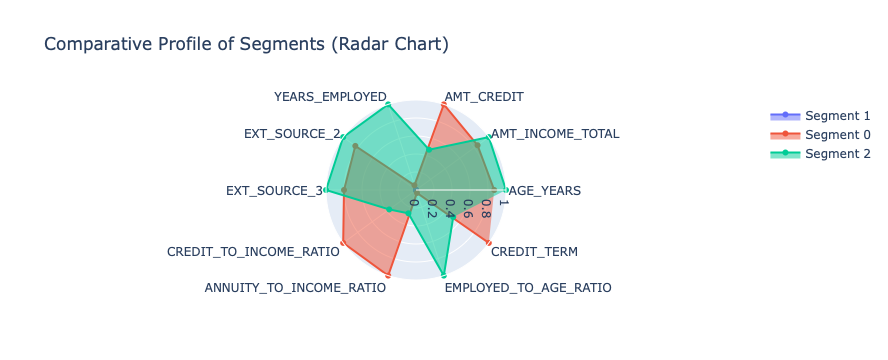

In [11]:
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Take only the numerical values from the analysis table
radar_data = segment_analysis.drop(columns=['Default_Rate (%)']).copy()

# IMPORTANT: For a radar chart, we must scale all values to a common range, like 0-1
scaler = MinMaxScaler()
radar_data_scaled = pd.DataFrame(scaler.fit_transform(radar_data), columns=radar_data.columns, index=radar_data.index)

# Create an interactive radar chart with Plotly
fig = go.Figure()

for i in radar_data_scaled.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_data_scaled.loc[i].values,
        theta=radar_data_scaled.columns,
        fill='toself',
        name=f'Segment {i}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,
  title="Comparative Profile of Segments (Radar Chart)"
)
fig.show()

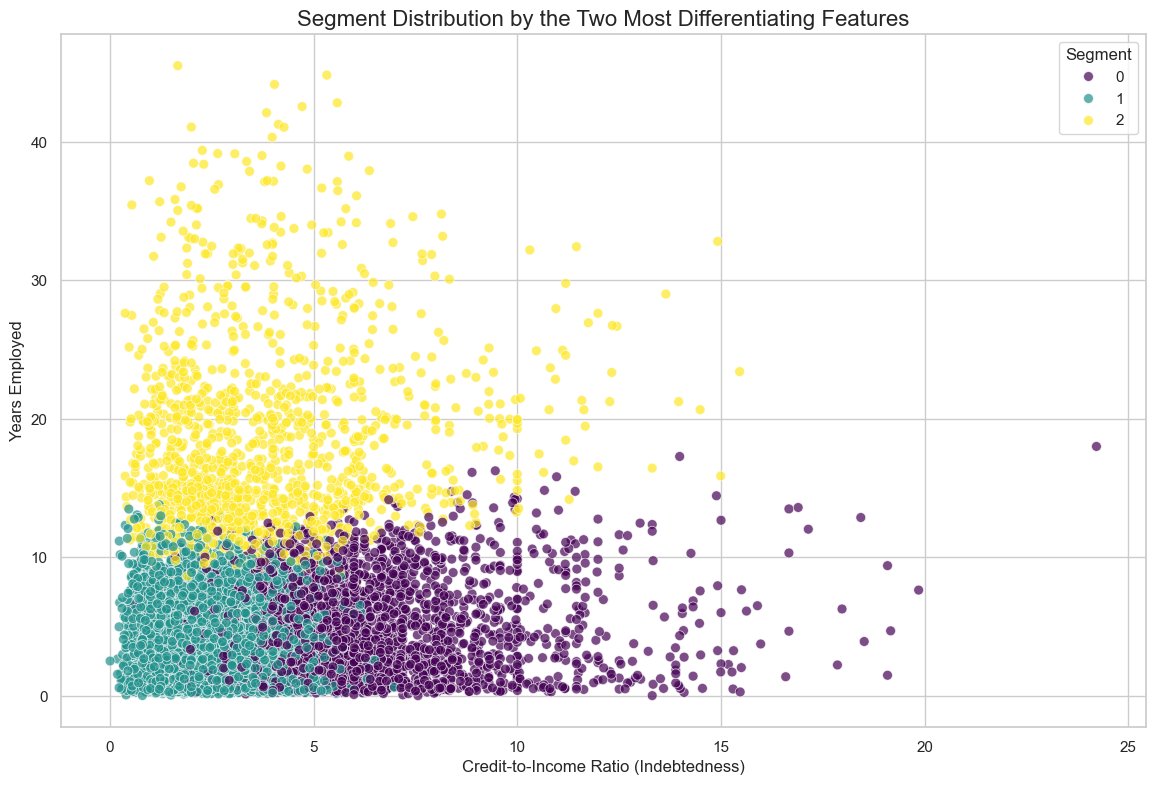

In [12]:
# Since the dataset is very large, let's take a sample for better readability of the plot
data_sample = data.sample(n=10000, random_state=42)

plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=data_sample,
    x='CREDIT_TO_INCOME_RATIO', 
    y='YEARS_EMPLOYED', 
    hue='Segment',       # Color the points by segment
    palette='viridis',
    alpha=0.7,
    s=50                 # Point size
)

plt.title('Segment Distribution by the Two Most Differentiating Features', fontsize=16)
plt.xlabel('Credit-to-Income Ratio (Indebtedness)', fontsize=12)
plt.ylabel('Years Employed', fontsize=12)
plt.legend(title='Segment')
plt.grid(True)
plt.show()

In [13]:
# === Export artifacts for LR & Streamlit ===
from pathlib import Path
import json, numpy as np, pandas as pd
from joblib import dump
import sklearn, sys

art = Path("artifacts"); art.mkdir(exist_ok=True)

# 1) Find the processed X that was used for training (and convert to dense)
X_proc = None
for name in ["processed_data_winsorized", "processed_trim", "processed_data"]:
    if name in globals():
        X_proc = globals()[name]
        break
assert X_proc is not None, "Processed data (processed_*) not found."

if hasattr(X_proc, "toarray"):
    X_proc = X_proc.toarray()
X_proc = np.asarray(X_proc, dtype=float)

# 2) Winsorization boundaries (calculate from training data if not already available)
# Note: winsor_cols and quantiles are assumed to be 0.1%-99.9%
if "winsor_cols" not in globals():
    winsor_cols = [
        'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','CREDIT_TO_INCOME_RATIO',
        'ANNUITY_TO_INCOME_RATIO','CREDIT_TERM','AGE_YEARS','YEARS_EMPLOYED'
    ]
if "q_low" in globals() and "q_hi" in globals():
    q_low_dict = {k: float(v) for k, v in q_low.to_dict().items() if k in winsor_cols}
    q_hi_dict  = {k: float(v) for k, v in q_hi.to_dict().items()  if k in winsor_cols}
else:
    assert "data_for_model" in globals(), "data_for_model not found (required to derive winsor boundaries)."
    q_low_dict = {c: float(data_for_model[c].quantile(0.001)) for c in winsor_cols if c in data_for_model.columns}
    q_hi_dict  = {c: float(data_for_model[c].quantile(0.999)) for c in winsor_cols if c in data_for_model.columns}

# 3) Input schema (the columns the model expects)
if "data_for_model_winsorized" in globals():
    model_input_cols = list(data_for_model_winsorized.columns)
elif "data_for_model" in globals():
    model_input_cols = list(data_for_model.columns)
else:
    raise RuntimeError("Could not determine model input columns.")

# 4) Store categorical & numerical lists (useful for the Streamlit form)
if "categorical_features" not in globals():
    categorical_features = []
if "numeric_features" not in globals():
    numeric_features = []

# 5) OneHotEncoder categories (optional, but good for consistency in production)
try:
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    ohe_categories = {col: list(cats) for col, cats in zip(categorical_features, ohe.categories_)}
except Exception:
    ohe_categories = {}

# 6) Config.json
config = {
    "RANDOM_STATE": int(globals().get("RANDOM_STATE", 42)),
    "kmeans_k": int(getattr(kmeans_final, "n_clusters", 3)),
    "winsor_cols": winsor_cols,
    "winsor_low_quantile": 0.001,
    "winsor_high_quantile": 0.999,
    "winsor_low_bounds": q_low_dict,
    "winsor_high_bounds": q_hi_dict,
    "model_input_cols": model_input_cols,
    "categorical_features": categorical_features,
    "numeric_features": numeric_features,
    "ohe_categories": ohe_categories,
    "versions": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": sklearn.__version__,
    }
}
with open(art/"config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

# 7) Save the PREPROCESSOR and KMEANS used for training
dump(preprocessor, art/"preprocessor_kmeans.joblib")
dump(kmeans_final, art/"kmeans_k3.joblib")

print("Artifacts saved to → ./artifacts/:")
print(" - config.json")
print(" - preprocessor_kmeans.joblib")
print(" - kmeans_k3.joblib")

Artifacts saved to → ./artifacts/:
 - config.json
 - preprocessor_kmeans.joblib
 - kmeans_k3.joblib


In [14]:
# Create a sample from the 'data' DF, which contains segmented and engineered features
(data[['CREDIT_TO_INCOME_RATIO','YEARS_EMPLOYED','Segment']]
 .dropna()
 .sample(n=10_000, random_state=42)
 .to_parquet('artifacts/scatter_sample.parquet'))